# ATF4 Project
## Preliminary analysis of all-atom MD simulatins of the ATF4 protein

### Chuan Ping,  Urval Patel, Dr. Roche, Dr. Potoyan

In [7]:
import openmm as mm
import numpy as np
import matplotlib.pyplot as plt

import mdtraj as md
import MDAnalysis as mda

from contact_map import ContactFrequency, ContactDifference

import nglview as nv
import ipywidgets

%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.style.use('bmh')

In [8]:
ns_per_frame = 0.02
cutoffValue  = 0.25 # Above this value, a "contact" is deemed valid.

# Trajectories Analysis

In [9]:

#%%time
traj1 = md.load('C:/Users/upatel/Box/Dr.Julien Roche/MDsimulations/bzip600ns1/Analysis1/bzip1_noPBC20ps.xtc',top='C:/Users/upatel/Box/Dr.Julien Roche/MDsimulations/bzip600ns1/Analysis1/bzip_noPBC500ps.pdb')

# This step may take an ungodly amount of time. Centering coordinates is more for visualization.
# traj1.center_coordinates(traj1)
total_frame = traj1.n_frames
trajtotal=traj1
print("The total number of frames is: " + str(total_frame))
print("The total number of nanoseconds is " + str(int(ns_per_frame * total_frame)))

The total number of frames is: 30001
The total number of nanoseconds is 600


In [10]:
show1_simplified = nv.show_mdtraj(trajtotal)
topology1 = traj1.topology
print(topology1)
show1_simplified

<mdtraj.Topology with 1 chains, 76 residues, 1310 atoms, 1312 bonds>


NGLWidget(max_frame=30000)

## Rg,RMSD and Secondary Structures

In [11]:
# Select the Alpha Carbon atom of each residue of the three replicas
ca_1      = trajtotal.top.select('name CA')
ca_trajtotal = trajtotal.atom_slice(ca_1)

rmsd_1   = md.rmsd(ca_trajtotal, ca_trajtotal[0])
rg_1     = md.compute_rg(ca_trajtotal)

Text(0.5, 1.0, 'Distribution of Rg for the ATF4(276-351) Protein')

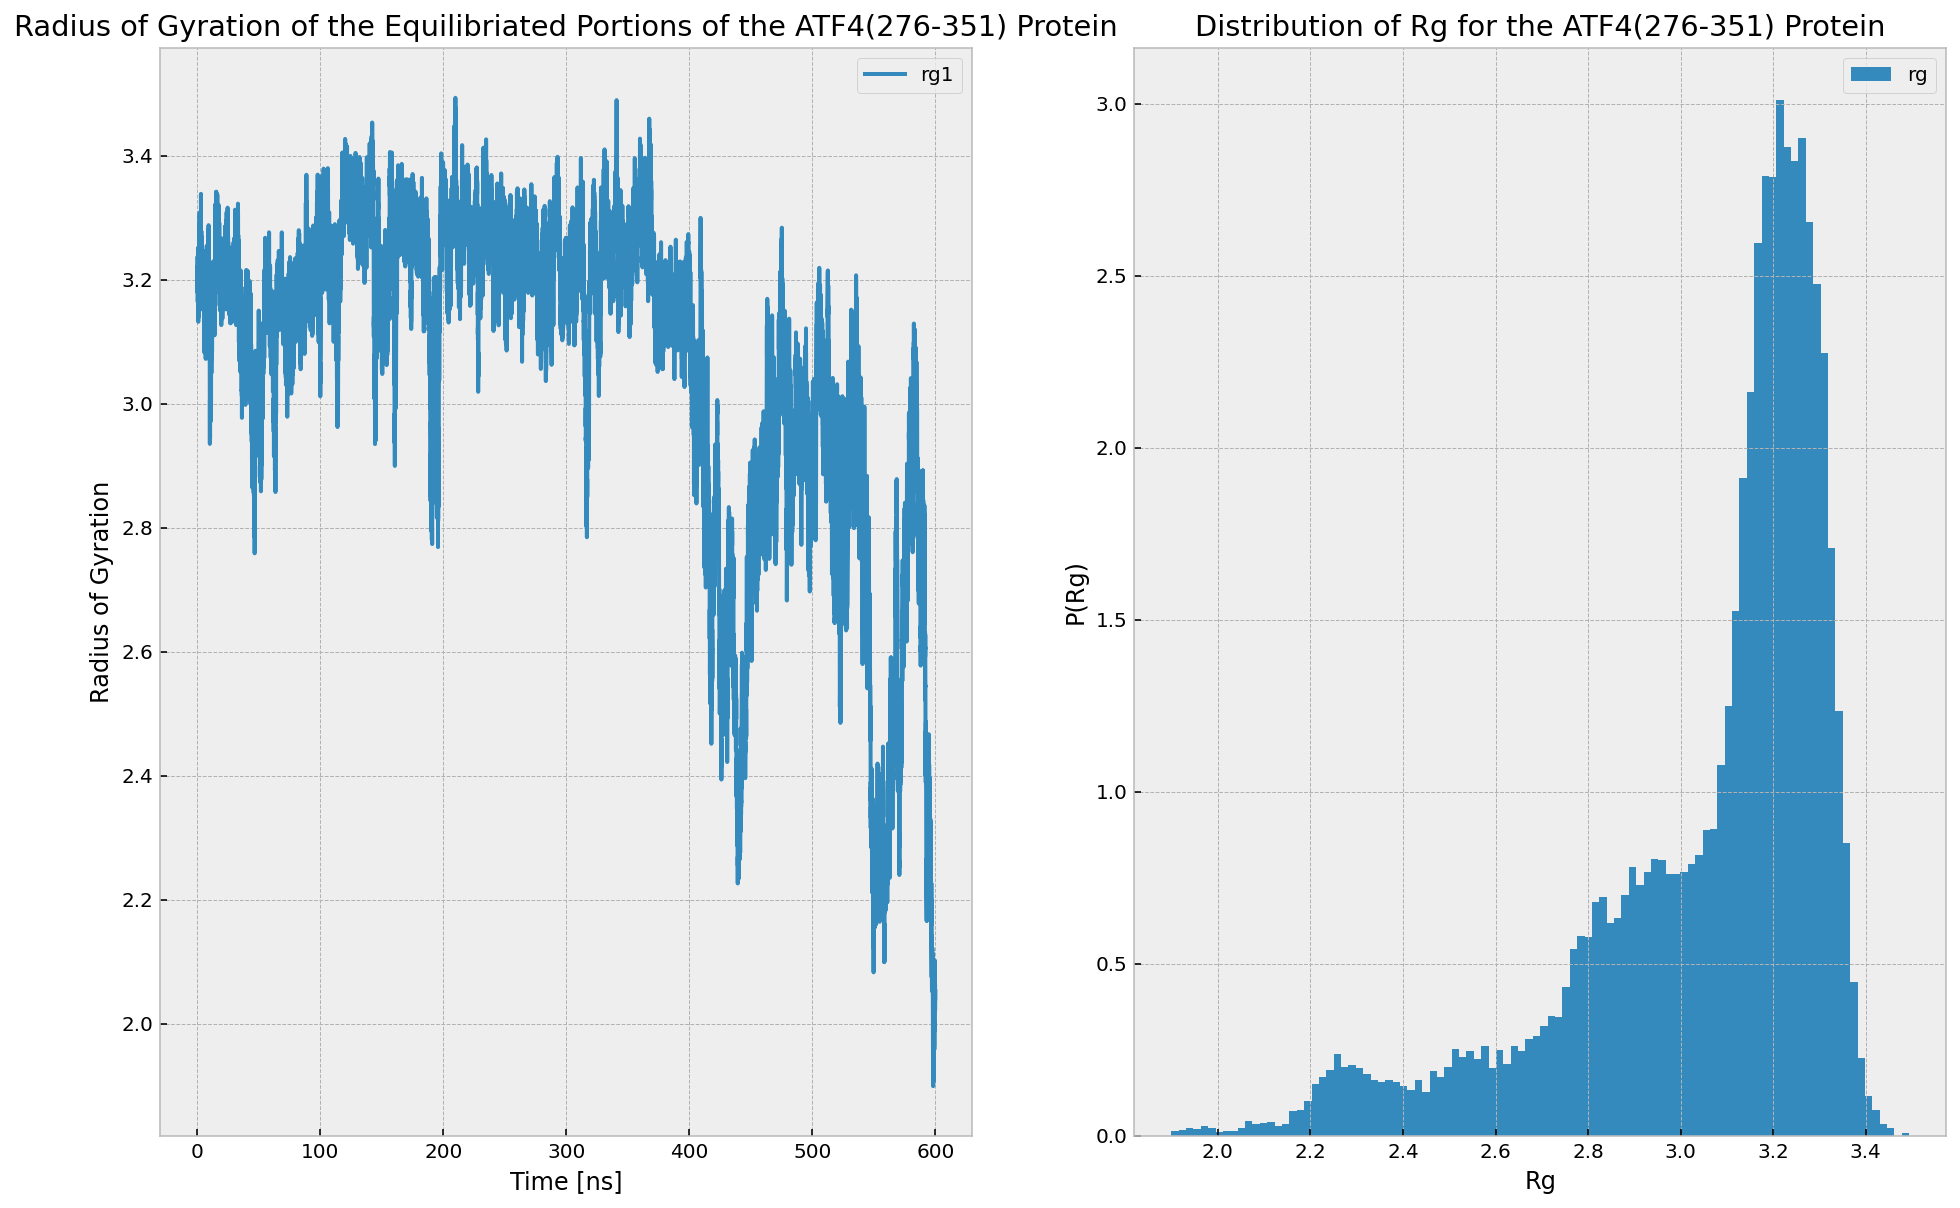

In [12]:
# Displays the radius of gyration of the trajectory
fig, (ax1, ax2)  = plt.subplots(ncols=2, figsize=(16, 10))
time = ns_per_frame * np.arange(len(rg_1))

ax1.plot(time, rg_1)
ax2.hist(rg_1, density=True, bins=100, label='rg')
ax1.legend(['rg1'])
ax2.legend(['rg'])
ax1.set(xlabel='Time [ns]', ylabel='Radius of Gyration') 
ax2.set(xlabel='Rg', ylabel='P(Rg)') 

ax1.set_title('Radius of Gyration of the Equilibriated Portions of the ATF4(276-351) Protein')
ax2.set_title('Distribution of Rg for the ATF4(276-351) Protein')

Text(0.5, 1.0, 'Distribution of RMSD for the ATF4(276-351) Protein')

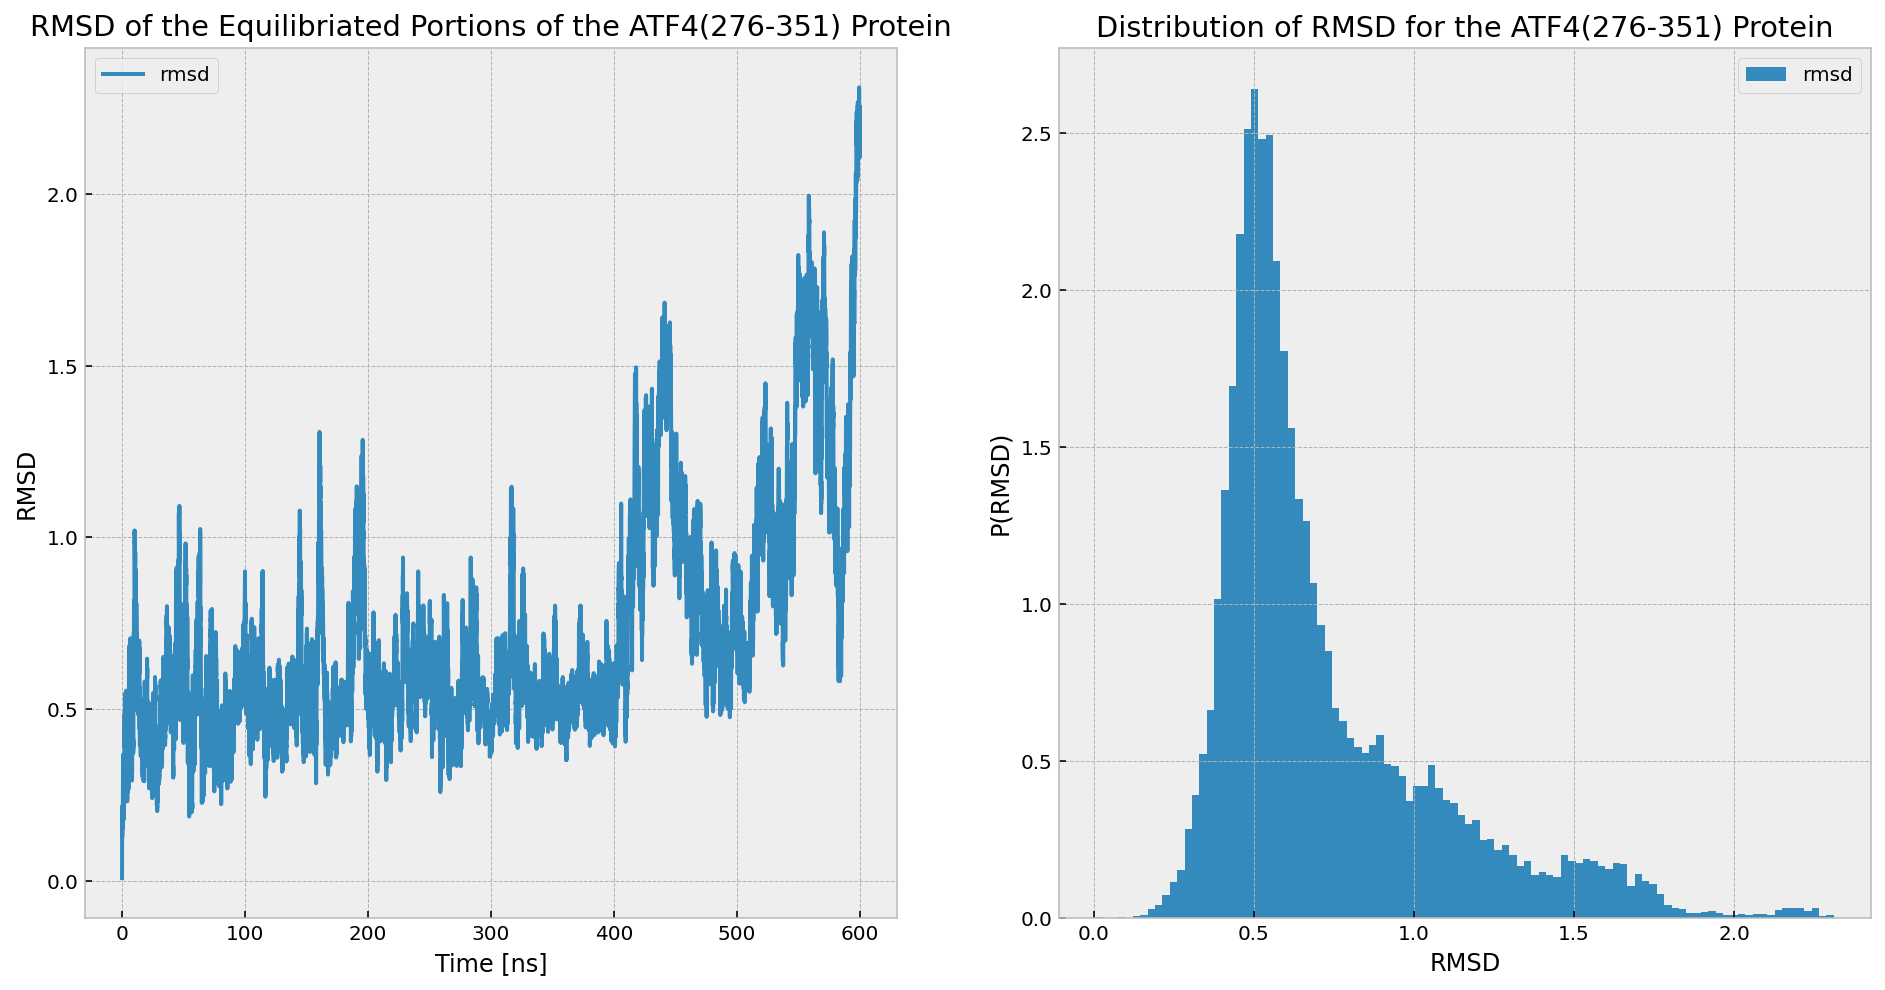

In [13]:
# Displays the radius of gyration of the trajectory
# Note that the RMSD plot is arbitrary. It only needs to show three roughly equilibriated portions. 
fig, (ax1, ax2)  = plt.subplots(ncols=2, figsize=(16,8))
time = ns_per_frame*np.arange(len(rmsd_1))

ax1.plot(time, rmsd_1)
ax2.hist(rmsd_1, density=True, bins=100, label='RMSD')
ax1.legend(['rmsd'])
ax2.legend(['rmsd'])
ax1.set(xlabel='Time [ns]', ylabel='RMSD') 
ax2.set(xlabel='RMSD', ylabel='P(RMSD)') 

ax1.set_title('RMSD of the Equilibriated Portions of the ATF4(276-351) Protein')
ax2.set_title('Distribution of RMSD for the ATF4(276-351) Protein')

## Secondary Structure of bzip

In [19]:
# BE VERY AWARE: this can KILL the kernel.
# traj1_simplest = traj1[::500]
secondary_structure_1 = md.compute_dssp(trajtotal, simplified=True)
print(len(secondary_structure_1[0]))

76


In [20]:
def generate_2nd_structure(traj_secondary_structure, array_of_types):
    """
    Takes a trajectory and compute the secondary structure frequencies of all residues.
    
    traj: the input trajectory to be analyzed
    array_of_types: an array containing symbols representing different secondary structures
    
    output: a dictionary. First dimension = len(array_of_types).Second dimension = traj.n_residues()
    """
    # Creates an empty dictionary for output
    output_dict = {}
    number_of_frames = len(traj_secondary_structure[0])
    number_of_residues = len(traj_secondary_structure)
    
    # Iterates over the input array
    for types in array_of_types:
        count_list = []
        
        # Iterates over the frames in the input trajectory
        for x in range(number_of_frames):
            count = 0
            
            # Iterates over the number of residues in the input trajectory
            for y in range(number_of_residues): 
                
                # Sums up the types of secondary structure and divide it by the total number of frames
                count += np.sum(np.char.count(traj_secondary_structure[y][x], types))
            count_list.append(count / number_of_residues)    
        output_dict[types] = count_list
                              
    return output_dict

In [21]:
def structured_residue(traj_secondary_structure, type_of_2nd_structure, prevalence):
    """
    Produces a list of residue indices whose corresponding residue in the trajectory predominates
    
    traj: the input trajectory to be analyzed
    type_of_2nd_structure: the type of secondary structure to be counted
    prevalence: the percentage of a certain secondary structure of a residue, above which the residue is
                determined to be "predominant" with that secondary structure
                
    output: a list of residue indices
    """
    output_list = []
    number_of_frames = len(traj_secondary_structure)
    number_of_residues = len(traj_secondary_structure[0])
    
    # Iterates over the residues in the input trajectory
    for x in range(number_of_residues):
        count_of_certain_type = 0
        
        # Iterates over the frames
        for y in range(number_of_frames):
            if traj_secondary_structure[y][x] == type_of_2nd_structure: count_of_certain_type += 1
        
        # Appends the index + 1 (residues start with MET1) to the list if deemed predominant
        if (count_of_certain_type / number_of_residues) > prevalence: output_list.append(x + 1) 
    
    return output_list

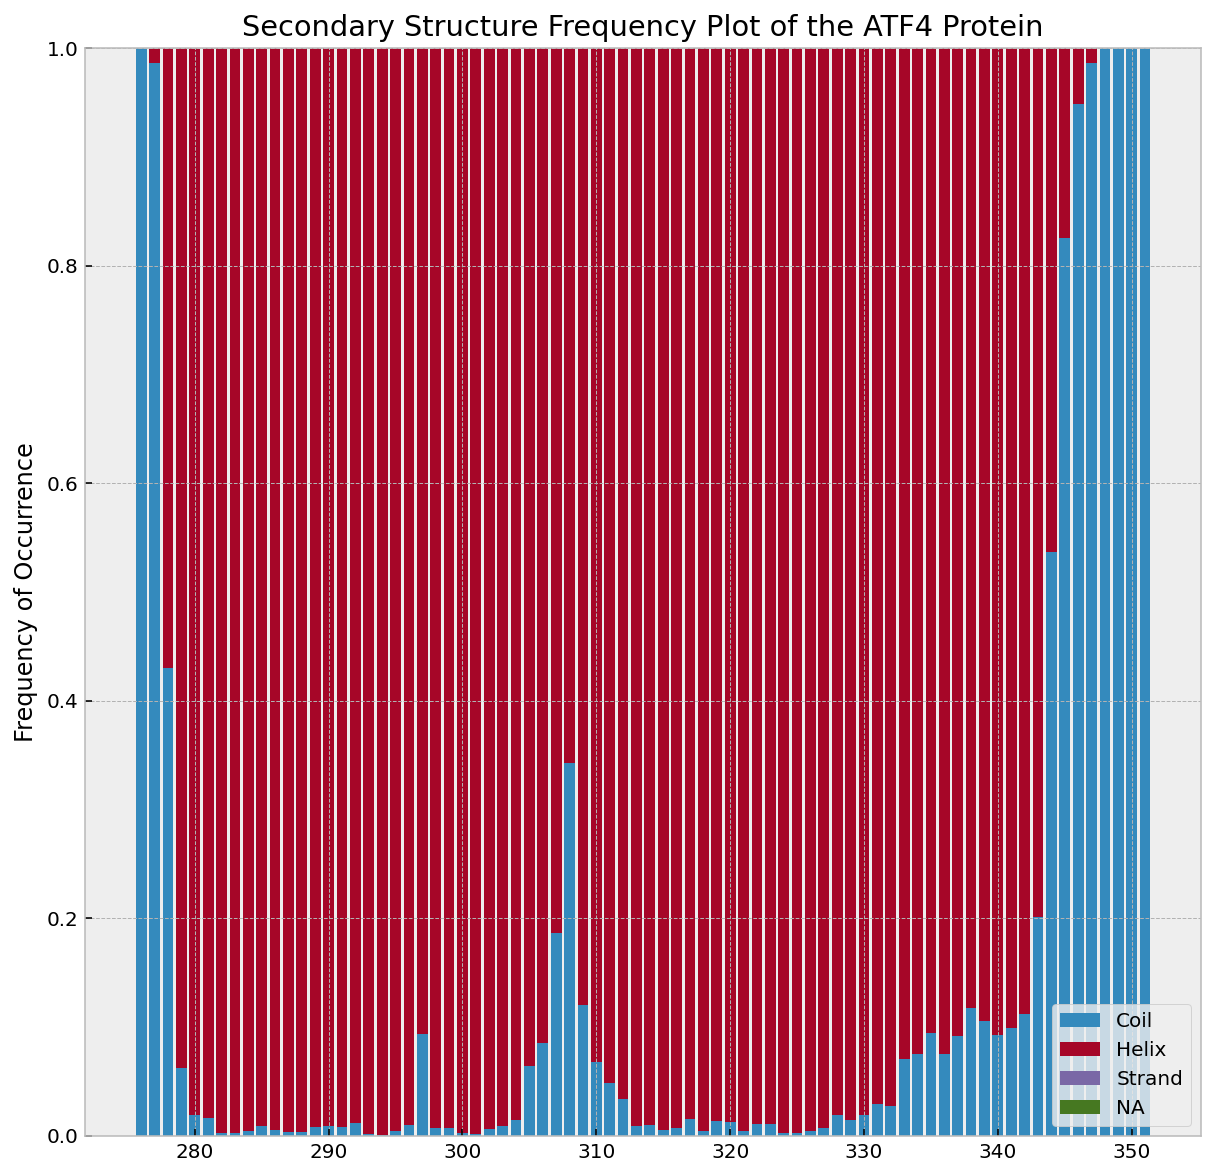

Wall time: 2min 4s


In [28]:
%%time
array_of_types = ['C','H','E','NA']
dict_2nd_structures = generate_2nd_structure(secondary_structure_1, array_of_types)
x_1 = dict_2nd_structures['C'] 
x_2 = dict_2nd_structures['H']
x_3 = dict_2nd_structures['E']
x_4 = dict_2nd_structures['NA']

# Note here! The x-axis starts at 1, not 0. This conforms to the residue index which starts at MET1


bins = [*range(276, 352, 1)]


fig, ax = plt.subplots(figsize=(10,10))
ax.bar(bins, x_1, label="Coil")
ax.bar(bins, x_2, bottom=x_1,label="Helix")
ax.bar(bins, x_3, bottom=np.array(x_1) + np.array(x_2),label="Strand")
ax.bar(bins, x_4, bottom=np.array(x_1) + np.array(x_2) + np.array(x_3),label="NA")

ax.set_ylabel('Frequency of Occurrence')
ax.set_title('Secondary Structure Frequency Plot of the ATF4 Protein')
ax.legend()

plt.show()

## Contat Map Analysis of bzip


In [35]:
# This crudely written function is called to remove duplicate residues in a list.

def removeDuplicates(list_input):
    """
    Remove duplicates in a list. This is used to prevent add_representation from malfunctioning
    due to one residue may have more than one interactions with others
    
    list: the original list that may or may not contain duplicates
    
    output: a list without replicates
    """
    output = []
    output.append(x) for x in list_input if x not in output
    return output

SyntaxError: invalid syntax (Temp/ipykernel_39108/1239047683.py, line 13)

In [36]:
# This function returns a list that can be quoted in visualization

def getContactIndex(contacts, topology, region1, region2, cutoffValue):
    """
    contacts: the contact map of the trajectory
    topology: the topology of the trajectory
    region1/2: the regions of residues of interest, as a range
    cutoffValue: the threshold of level of contacts
    
    returns a list containing the residue numbers of the residues that are in contact(this is for visualization)
    """
    resid_1_list = [] # Creates an empty list storing values of the residues
    resid_2_list = []
    for resid1 in region1:
        for contact in contacts.residue_contacts.most_common(topology.residue(resid1)):
            if contact[1] > cutoffValue and contact[0][1].index in region2:
                resid_1_list.append(contact[0][0].index + 1) # +1 to compensate for list starting with 0
                resid_2_list.append(contact[0][1].index + 1)
    return removeDuplicates(resid_1_list), removeDuplicates(resid_2_list)

In [37]:
# Writes the contact map between regions of interest into an output file

def contactBetweenRegions(contacts, topology, region1, region2, cutoffValue, outputFileName):
    """
    contacts: the contact map of the trajectory
    topology: the topology of the trajectory
    region1/2: the regions of residues of interest, as a range
    cutoffValue: the threshold of level of contacts
    
    returns 
    1) a txt file outlining important contacts between two regions of interest in the protein
    2) a list containing the residue numbers of the residues that are in contact(this is for visualization)
    """
    resid_1_list = [] # Creates two emply lists storing indices of the residues
    resid_2_list = []
    
    with open(outputFileName, 'w') as output:
        output.write(outputFileName + '\n\n')
        for resid1 in region1:
            for contact in contacts.residue_contacts.most_common(topology.residue(resid1)):
                if contact[1] > cutoffValue and contact[0][1].index in region2:
                    resid_1_list.append(contact[0][0].index)
                    resid_2_list.append(contact[0][1].index)
                    output.write(str(contact) + '\n\n')

In [38]:
def contact_dict(topology, contact, list_of_contacts, cutoffValue):
    """
    Produces a dictionary of the contacts whose value is above cutoffValue; the residue index is in the input list
    
    topology: the topology of the protein of interest
    contact: the contact information of the relevant residues
    list_of_contacts: produce of the getContactIndex function
    
    return: A dictionary. Key = residue index + 1; Value = a list containing the contact pairs and the contact frequency
            note that the contact frequency needs a better definition (May 10)
    """
    ranked_list = [] # Defines the output list
    dict_for_rank = {}
    
    # Iterates over all in list_of_contacts
    for residue_index in list_of_contacts:
        
        # Obtains the entire list of contacts for a specific residue index for further procession
        contact_list_for_residue = contact.residue_contacts.most_common(topology1.residue(residue_index))
        
        # Initiates a list to be written into the dictionary
        list_to_dict = []
        
        # Iterates over the pair of contacts in the list
        for contactPair in contact_list_for_residue:
            if contactPair[1] > cutoffValue:
                list_to_dict.append(contactPair)
        # Adds the now-valid contact list of the specific residue into the dictionary
        # Note that the dictionary key must have +1 for the residue index, for the residue index starts at 0 but
        # the first residue is always MET1 hence having an index 1. 
        dict_for_rank[residue_index + 1] = list_to_dict
        
    return dict_for_rank

Wall time: 26min 33s


Text(0, 0.5, 'Residue')

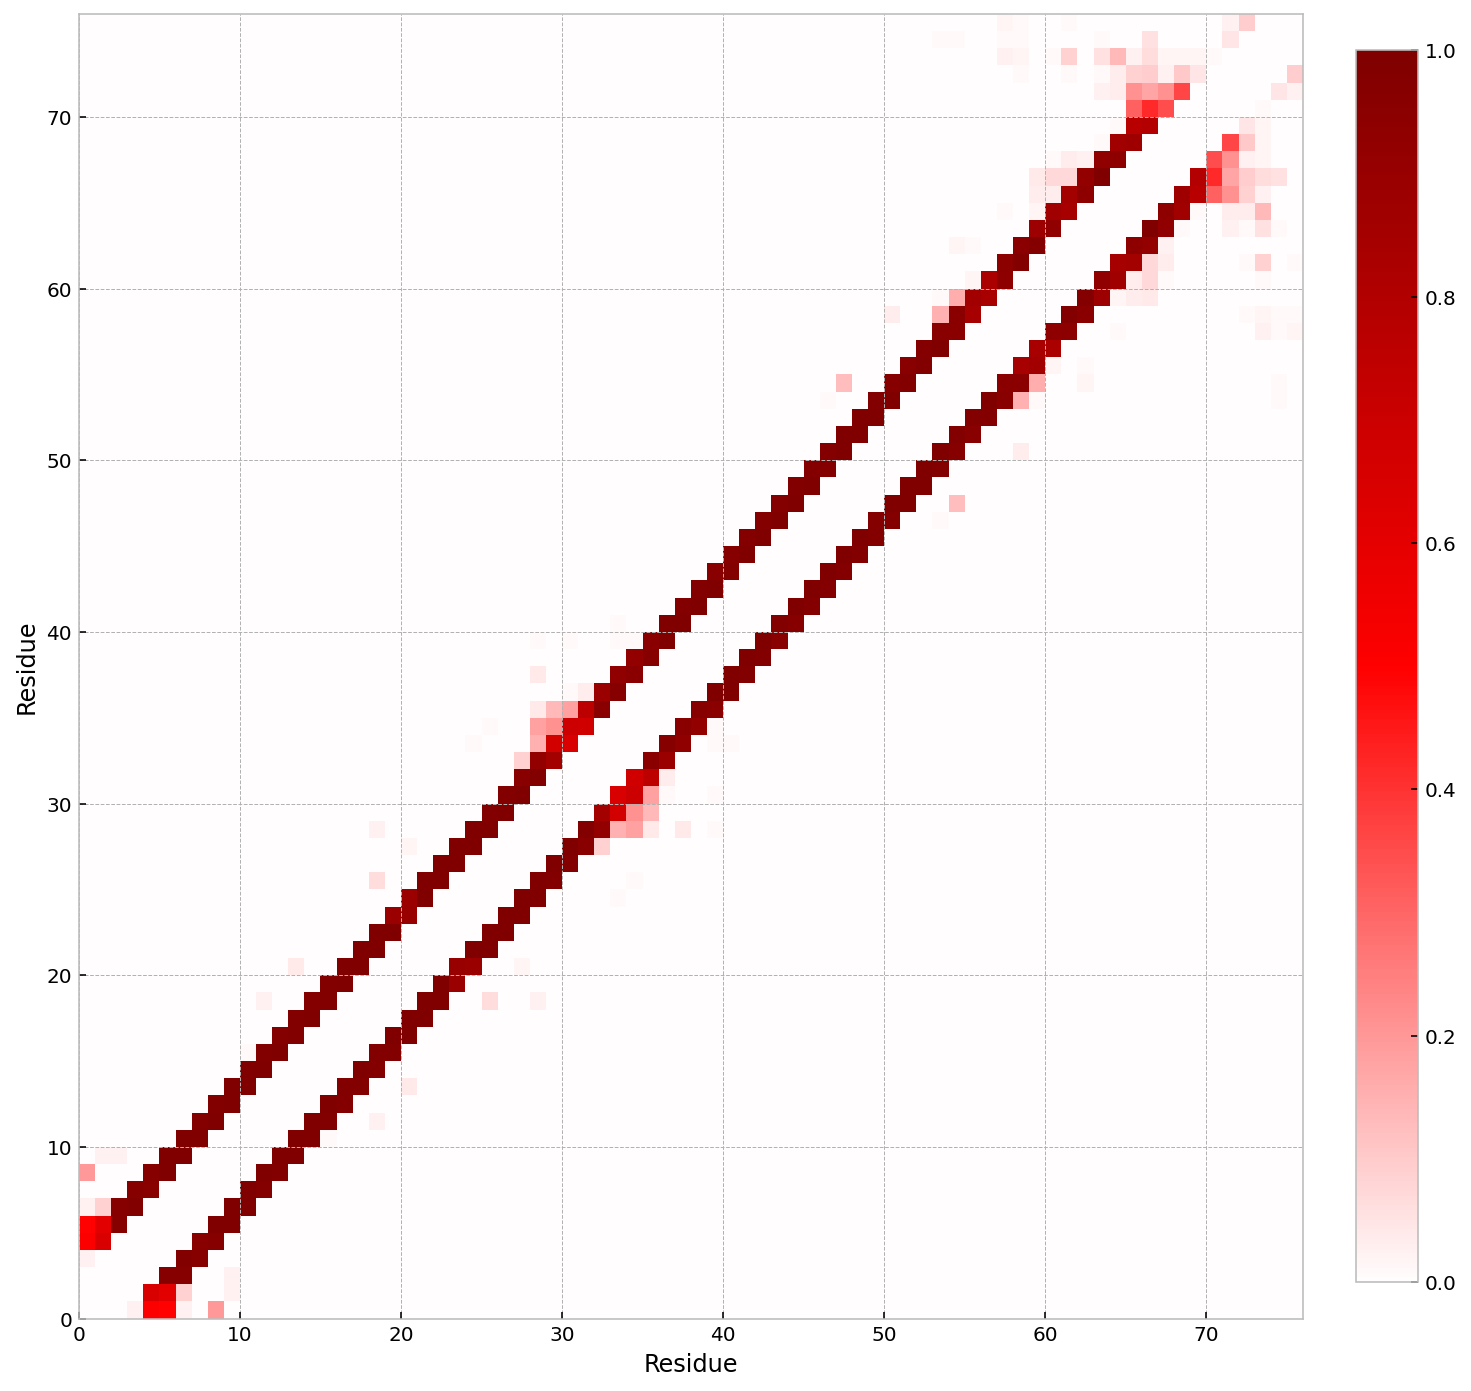

In [29]:
%%time
traj1_contacts = ContactFrequency(trajtotal)
fig, ax = traj1_contacts.residue_contacts.plot(figsize=(12,12))
plt.xlabel("Residue")
plt.ylabel("Residue")

# PCA of bzip

In [45]:
from __future__ import print_function
%matplotlib inline
import mdtraj as md
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [54]:
pca1 = PCA(n_components=3)
trajtotal.superpose(trajtotal, 0)

<mdtraj.Trajectory with 30001 frames, 1310 atoms, 76 residues, and unitcells at 0x1adaaed2fa0>

In [55]:
reduced_cartesian = pca1.fit_transform(trajtotal.xyz.reshape(trajtotal.n_frames, trajtotal.n_atoms * 3))
print(reduced_cartesian.shape)



(30001, 3)


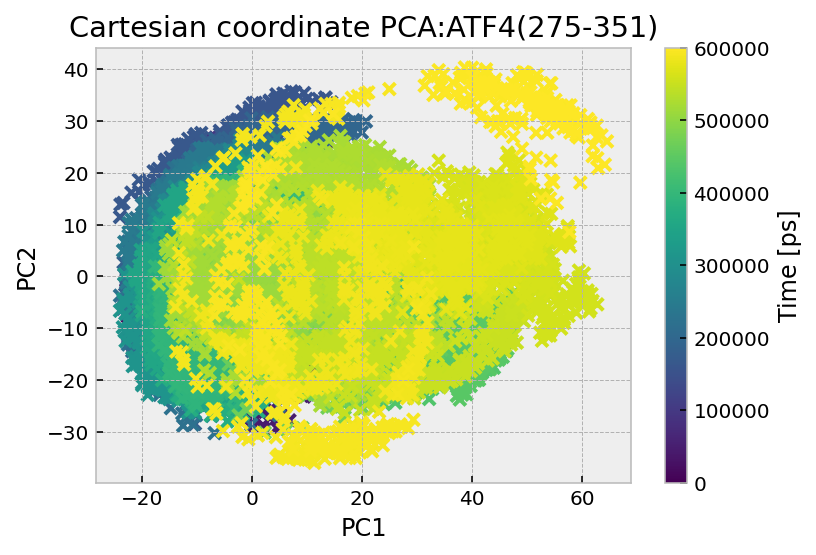

In [56]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=trajtotal.time)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Cartesian coordinate PCA:ATF4(275-351)')
cbar = plt.colorbar()
cbar.set_label('Time [ps]')

MemoryError: Unable to allocate 95.8 GiB for an array with shape (30001, 857395) and data type float32